# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.38.2', '2.3.0+cu121')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading dataset

In [4]:
import datasets

###1. Load Dataset
task_to_keys = {
    "HateSpeech" : ("text", None),
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "HateSpeech"
raw_datasets = datasets.load_dataset("hate_speech18")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})

In [5]:
from datasets import DatasetDict

train_val_split = raw_datasets['train'].train_test_split(test_size=0.1)
test_val_split = train_val_split['test'].train_test_split(test_size=0.5)

final_dataset  = DatasetDict({
    'train': train_val_split['train'],
    'validation': test_val_split['train'],
    'test': test_val_split['test']
})

In [6]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 9849
    })
    validation: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 547
    })
    test: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 548
    })
})

In [7]:
label_list = final_dataset['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'noHate': 0, 'hate': 1, 'idk/skip': 2, 'relation': 3}

In [8]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'noHate', 1: 'hate', 2: 'idk/skip', 3: 'relation'}

## 2. Model & Tokenization

In [9]:
import numpy as np 
num_labels = np.unique(final_dataset['train']['label']).size
num_labels

4

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

/home/jupyter-st124952/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [11]:
def tokenize_function(examples):
    sentence_key = 'text'
    result = tokenizer(examples[sentence_key], padding="max_length", truncation=True, max_length=128)
    return result

In [12]:
tokenized_datasets = final_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/9849 [00:00<?, ? examples/s]

Map:   0%|          | 0/547 [00:00<?, ? examples/s]

Map:   0%|          | 0/548 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9849
    })
    validation: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 547
    })
    test: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 548
    })
})

In [13]:
column_dataset = ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
column_dataset 

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']

In [14]:
tokenized_datasets = tokenized_datasets.remove_columns([col for col in tokenized_datasets['train'].column_names if col not in column_dataset])

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format(type='torch', columns=['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 2196, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [16]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] never. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [17]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## 4. Preparing the dataloader

In [18]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [19]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(9000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(500))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(500))

In [20]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [21]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [22]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "noHate",
    "1": "hate",
    "2": "idk/skip",
    "3": "relation"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "idk/skip": 2,
    "noHate": 0,
    "relation": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [23]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [24]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [25]:
configuration

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "noHate",
    "1": "hate",
    "2": "idk/skip",
    "3": "relation"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "hate": 1,
    "idk/skip": 2,
    "noHate": 0,
    "relation": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [26]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [27]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher: Module,
    student: Module,
    layer: str = 'odd'
) -> None:
    """
    Recursively copies the weights of the teacher to the student.
    This function is meant to be first called on a BertFor... model, but is then called on every child module recursively.
    For the encoder, only half of the teacher's layers are copied, based on the 'layer' parameter:
    - 'odd': Copies layers {1, 3, 5, 7, 9, 11} (indices 0, 2, 4, 6, 8, 10).
    - 'even': Copies layers {2, 4, 6, 8, 10, 12} (indices 1, 3, 5, 7, 9, 11).
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer=layer)
    # Else if the part is an encoder, copy the specified layers
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        for i in range(len(student_encoding_layers)):
            if layer == 'odd':
                teacher_index = 2 * i  # Indices: 2, 4, 6, 8, 10, 12
            elif layer == 'even':
                teacher_index = 2 * i + 1  # Indices: 1, 3, 5, 7, 9, 11
            else:
                raise ValueError("Invalid layer parameter. Must be 'odd' or 'even'.")
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[teacher_index].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())
    return student

In [28]:
odd_model = distill_bert_weights(teacher_model, student=model, layer='odd')
even_model =  distill_bert_weights(teacher_model, student=model, layer='even')

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(odd_model))

Teacher parameters : 109485316
Student parameters : 66958084


In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(even_model))

Teacher parameters : 109485316
Student parameters : 66958084


In [31]:
count_parameters(odd_model)/count_parameters(teacher_model) * 100

61.157136359728824

In [32]:
count_parameters(even_model)/count_parameters(teacher_model) * 100

61.157136359728824

In [33]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [34]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [35]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [36]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer_odd = optim.Adam(params=odd_model.parameters(), lr=lr)
optimizer_even = optim.Adam(params=even_model.parameters(), lr=lr)

In [37]:
odd_model.to(device)
even_model.to(device)
teacher_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 7. Learning rate scheduler

In [38]:
from transformers import get_scheduler
num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

# Scheduler for odd_model
lr_scheduler_odd = get_scheduler(
    name="linear",
    optimizer=optimizer_odd,  # Optimizer for odd_model
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Scheduler for even_model
lr_scheduler_even = get_scheduler(
    name="linear",
    optimizer=optimizer_even,  # Optimizer for even_model
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

## 8. Metric

In [39]:
#!pip3 install evaluate

In [40]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    # metric = evaluate.load("glue", task_name)
    metric = evaluate.load("accuracy")
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [41]:
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
import numpy as np


def train_distilled_model(student_model, optimizer, lr_scheduler, student_type="odd"):
    """
    Train a distilled BERT student model (odd or even layers) using knowledge distillation.
    
    Args:
        student_model: The student model to train (odd or even layers)
        optimizer: Optimizer for the student model
        lr_scheduler: Learning rate scheduler
        student_type: String identifier for the model ("odd" or "even")
    
    Returns:
        dict: Training and evaluation metrics history
    """
    print(f"\n this is a training model for {student_type} distilled model...\n")

    progress_bar = tqdm(range(num_training_steps))
    student_model.to(device)
    teacher_model.to(device)

    # Store loss and metric history
    train_losses, train_cls, train_div, train_cos = [], [], [], []
    eval_losses, eval_metrics_list = [], []
    accuracies_per_epoch = []  # Track accuracy for each epoch

    # Track average metrics across epochs
    avg_metrics = {"accuracy": 0}

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        total_loss, loss_cls_total, loss_div_total, loss_cos_total = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs_student = student_model(**batch)
            with torch.no_grad():
                outputs_teacher = teacher_model(**batch)

            # Losses
            loss_cls = outputs_student.loss
            temperature = 2.0
            loss_div = criterion_div(
                F.log_softmax(outputs_student.logits / temperature, dim=-1),
                F.softmax(outputs_teacher.logits / temperature, dim=-1)
            ) * (temperature ** 2)
            loss_cos = criterion_cos(
                outputs_teacher.logits,
                outputs_student.logits,
                torch.ones(outputs_teacher.logits.size(0)).to(device)
            )

            # Total loss (weighted average)
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Accumulate losses
            total_loss += loss.item()
            loss_cls_total += loss_cls.item()
            loss_div_total += loss_div.item()
            loss_cos_total += loss_cos.item()

            progress_bar.update(1)

        # Store training losses
        train_losses.append(total_loss / len(train_dataloader))
        train_cls.append(loss_cls_total / len(train_dataloader))
        train_div.append(loss_div_total / len(train_dataloader))
        train_cos.append(loss_cos_total / len(train_dataloader))

        # Evaluation
        student_model.eval()
        eval_loss, all_preds, all_labels = 0, [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)
                loss_eval = outputs.loss
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss_eval.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        # Compute metrics using the evaluate library
        metric = evaluate.load("accuracy")
        metrics = metric.compute(predictions=all_preds, references=all_labels)
        accuracies_per_epoch.append(metrics["accuracy"])  # Store accuracy for each epoch

        eval_losses.append(eval_loss / len(eval_dataloader))
        eval_metrics_list.append(metrics)

        # Logging
        print(f"\n Epoch {epoch+1}/{num_epochs} — {student_type} distilled model")
        print(f" Train Loss:     {train_losses[-1]:.4f}")
        print(f'  - Loss_cls: {train_cls[-1]:.4f}')
        print(f'  - Loss_div: {train_div[-1]:.4f}')
        print(f'  - Loss_cos: {train_cos[-1]:.4f}')
        print(f" Eval Loss:      {eval_losses[-1]:.4f}")
        print(f" Eval Metrics:   Acc={metrics['accuracy']:.4f}")

    # Print average metrics
    print(f"\n Average Metrics for {student_type} distilled model over {num_epochs} epochs:")
    print(f"  Accuracy: {avg_metrics['accuracy']/num_epochs:.4f}")

    # Save the model
    model_path = f"./{student_type}_model.pt"
    torch.save(student_model.state_dict(), model_path)
    print(f"\n{student_type.capitalize()} model saved to {model_path}")

    # Return results for plotting or further analysis
    return {
        "train_losses": train_losses,
        "train_cls": train_cls,
        "train_div": train_div,
        "train_cos": train_cos,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "accuracies_per_epoch": accuracies_per_epoch,  # Return accuracies for plotting
        "final_avg_metrics": {"accuracy": avg_metrics["accuracy"]/num_epochs}
    }

In [42]:
print("\n---- ODD RESULTS ---")
odd_results = train_distilled_model(odd_model, optimizer_odd, lr_scheduler_odd, "odd")

print("\n---- EVEN RESULTS ---")
even_results = train_distilled_model(even_model, optimizer_even, lr_scheduler_even, "even")


---- ODD RESULTS ---

 this is a training model for odd distilled model...



  0%|          | 0/1410 [00:00<?, ?it/s]


 Epoch 1/5 — odd distilled model
 Train Loss:     0.3528
  - Loss_cls: 0.7406
  - Loss_div: 0.1946
  - Loss_cos: 0.1233
 Eval Loss:      0.6335
 Eval Metrics:   Acc=0.8820

 Epoch 2/5 — odd distilled model
 Train Loss:     0.3217
  - Loss_cls: 0.6298
  - Loss_div: 0.2343
  - Loss_cos: 0.1011
 Eval Loss:      0.6511
 Eval Metrics:   Acc=0.8960

 Epoch 3/5 — odd distilled model
 Train Loss:     0.3064
  - Loss_cls: 0.5689
  - Loss_div: 0.2531
  - Loss_cos: 0.0973
 Eval Loss:      0.6271
 Eval Metrics:   Acc=0.9000

 Epoch 4/5 — odd distilled model
 Train Loss:     0.2976
  - Loss_cls: 0.5339
  - Loss_div: 0.2632
  - Loss_cos: 0.0955
 Eval Loss:      0.6299
 Eval Metrics:   Acc=0.8980

 Epoch 5/5 — odd distilled model
 Train Loss:     0.2944
  - Loss_cls: 0.5210
  - Loss_div: 0.2676
  - Loss_cos: 0.0946
 Eval Loss:      0.6252
 Eval Metrics:   Acc=0.9020

 Average Metrics for odd distilled model over 5 epochs:
  Accuracy: 0.0000

Odd model saved to ./odd_model.pt

---- EVEN RESULTS ---



  0%|          | 0/1410 [00:00<?, ?it/s]


 Epoch 1/5 — even distilled model
 Train Loss:     0.2980
  - Loss_cls: 0.5336
  - Loss_div: 0.2673
  - Loss_cos: 0.0930
 Eval Loss:      0.6033
 Eval Metrics:   Acc=0.8960

 Epoch 2/5 — even distilled model
 Train Loss:     0.2935
  - Loss_cls: 0.5182
  - Loss_div: 0.2721
  - Loss_cos: 0.0902
 Eval Loss:      0.6500
 Eval Metrics:   Acc=0.8940

 Epoch 3/5 — even distilled model
 Train Loss:     0.2894
  - Loss_cls: 0.5030
  - Loss_div: 0.2761
  - Loss_cos: 0.0891
 Eval Loss:      0.6504
 Eval Metrics:   Acc=0.8920

 Epoch 4/5 — even distilled model
 Train Loss:     0.2870
  - Loss_cls: 0.4934
  - Loss_div: 0.2788
  - Loss_cos: 0.0889
 Eval Loss:      0.6364
 Eval Metrics:   Acc=0.8940

 Epoch 5/5 — even distilled model
 Train Loss:     0.2849
  - Loss_cls: 0.4842
  - Loss_div: 0.2818
  - Loss_cos: 0.0885
 Eval Loss:      0.6215
 Eval Metrics:   Acc=0.8980

 Average Metrics for even distilled model over 5 epochs:
  Accuracy: 0.0000

Even model saved to ./even_model.pt


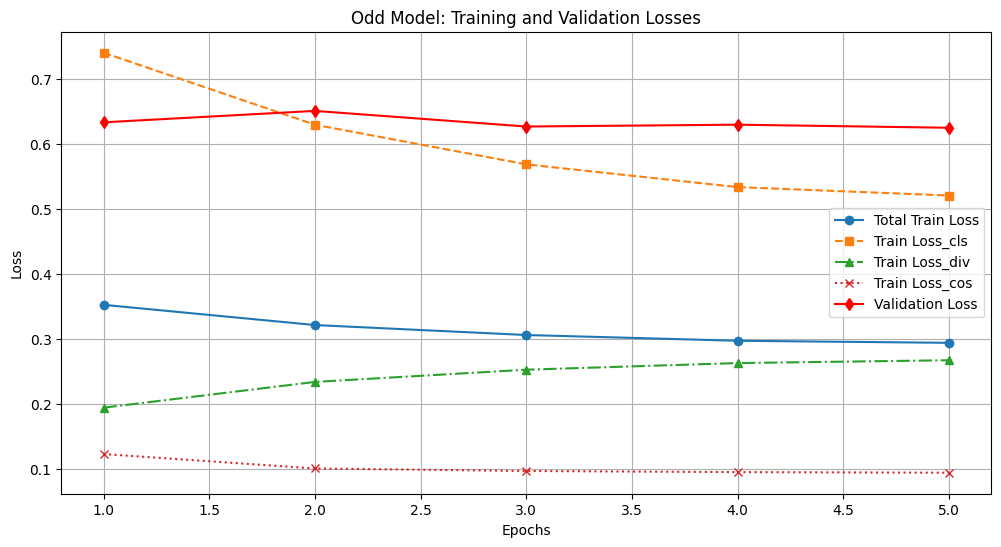

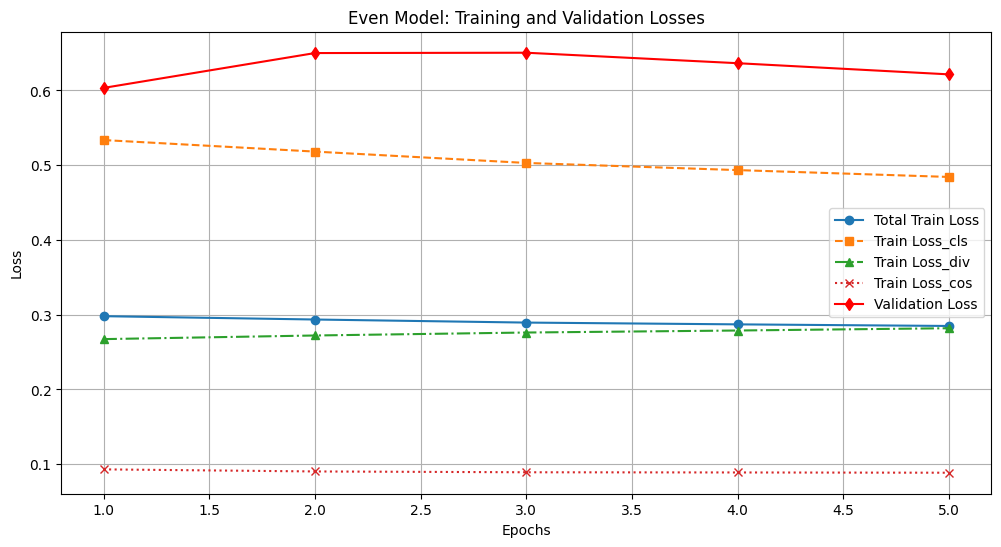

In [43]:
import matplotlib.pyplot as plt

def plot_losses(results, student_type="odd"):
    epochs_list = range(1, len(results["train_losses"]) + 1)

    train_losses = results["train_losses"]
    train_losses_cls = results["train_cls"]
    train_losses_div = results["train_div"]
    train_losses_cos = results["train_cos"]
    eval_losses = results["eval_losses"]

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label="Total Train Loss", marker='o')
    plt.plot(epochs_list, train_losses_cls, label="Train Loss_cls", marker='s', linestyle="--")
    plt.plot(epochs_list, train_losses_div, label="Train Loss_div", marker='^', linestyle="-.")
    plt.plot(epochs_list, train_losses_cos, label="Train Loss_cos", marker='x', linestyle=":")
    plt.plot(epochs_list, eval_losses, label="Validation Loss", marker='d', linestyle="-", color="red")

    plt.title(f'{student_type.capitalize()} Model: Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(odd_results, "odd")
plot_losses(even_results, "even")

### LoRA

In [44]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification

lora_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,           
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

lora_model = get_peft_model(lora_model, lora_config)
lora_model.print_trainable_parameters() 

/home/jupyter-st124952/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 294,912 || all params: 109,780,228 || trainable%: 0.2686385384442816


## LoRA Optimizer

In [45]:
from transformers import AdamW
from transformers import get_scheduler

optimizer_lora = AdamW(lora_model.parameters(), lr=2e-5, weight_decay=0.01)

num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(0.1 * num_training_steps)

scheduler_lora = get_scheduler(
    name="linear",
    optimizer=optimizer_lora,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

/home/jupyter-st124952/.local/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [46]:
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import evaluate


def train_lora_model(lora_model, teacher_model, optimizer_lora, scheduler_lora, train_dataloader, eval_dataloader, criterion_div, criterion_cos, num_epochs=5, device="cuda", output_file="lora_training_results.pt"):
    """
    Train a LoRA model using knowledge distillation and save results as a .pt file.
    
    Args:
        lora_model: The LoRA-based student model.
        teacher_model: The pretrained teacher model.
        optimizer_lora: Optimizer for the LoRA model.
        scheduler_lora: Learning rate scheduler for the optimizer.
        train_dataloader: Dataloader for training data.
        eval_dataloader: Dataloader for evaluation data.
        criterion_div: Loss function for divergence loss.
        criterion_cos: Loss function for cosine similarity loss.
        num_epochs: Number of training epochs.
        device: The device to run the training on ("cuda" or "cpu").
        output_file: Path to save training results (.pt format).
    
    Returns:
        dict: Training and evaluation metrics history.
    """
    print("\nTraining LoRA Model...\n")

    lora_model.to(device)
    teacher_model.to(device)

    # Define loss criteria
    metric = evaluate.load("accuracy")

    # Track loss and accuracy
    train_losses, train_losses_cls, train_losses_div, train_losses_cos = [], [], [], []
    eval_losses, eval_metrics_list = [], []
    avg_metrics = {"accuracy": 0}

    # To track accuracy per epoch
    accuracies_per_epoch = []

    # Progress bar
    num_training_steps = num_epochs * len(train_dataloader)
    progress_bar = tqdm(range(num_training_steps), desc="Training LoRA Model")

    for epoch in range(num_epochs):
        # --- Training ---
        lora_model.train()
        teacher_model.eval()
        train_loss, train_loss_cls, train_loss_div, train_loss_cos = 0, 0, 0, 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = lora_model(**batch)
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            assert outputs.logits.size() == output_teacher.logits.size(), "Logits size mismatch"

            # Compute losses
            loss_cls = outputs.loss
            temperature = 2.0
            loss_div = criterion_div(
                nn.functional.log_softmax(outputs.logits / temperature, dim=-1),
                nn.functional.softmax(output_teacher.logits / temperature, dim=-1)
            ) * (temperature ** 2)
            target = torch.ones(outputs.logits.size(0), device=device)
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, target)

            # Total loss (weighted average)
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Backpropagation
            loss.backward()
            optimizer_lora.step()
            scheduler_lora.step()
            optimizer_lora.zero_grad()
            progress_bar.update(1)

            # Accumulate losses
            train_loss += loss.item()
            train_loss_cls += loss_cls.item()
            train_loss_div += loss_div.item()
            train_loss_cos += loss_cos.item()

        # Store training losses
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'LoRA Model - Epoch {epoch+1}: Train loss {train_losses[-1]:.4f}')
        print(f'  - Loss_cls: {train_losses_cls[-1]:.4f}')
        print(f'  - Loss_div: {train_losses_div[-1]:.4f}')
        print(f'  - Loss_cos: {train_losses_cos[-1]:.4f}')

        # --- Evaluation ---
        lora_model.eval()
        eval_loss, all_preds, all_labels = 0, [], []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = lora_model(**batch)
                loss_cls = outputs.loss
                preds = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

        eval_metric = metric.compute(predictions=all_preds, references=all_labels)
        avg_metrics["accuracy"] += eval_metric["accuracy"]

        eval_losses.append(eval_loss / len(eval_dataloader))
        eval_metrics_list.append(eval_metric)

        accuracies_per_epoch.append(eval_metric["accuracy"])  # Store accuracy for each epoch

        print(f"LoRA Model - Epoch {epoch+1}: Val Acc {eval_metric['accuracy']:.4f}")

    # Compute final average accuracy
    final_avg_accuracy = avg_metrics["accuracy"] / num_epochs
    print(f'\nLoRA Model - Avg Accuracy: {final_avg_accuracy:.4f}')

    # Save results as .pt file
    results = {
        "train_losses": train_losses,
        "train_cls": train_losses_cls,
        "train_div": train_losses_div,
        "train_cos": train_losses_cos,
        "eval_losses": eval_losses,
        "metrics_per_epoch": eval_metrics_list,
        "accuracies_per_epoch": accuracies_per_epoch,  # Added accuracies per epoch
        "final_avg_metrics": {"accuracy": final_avg_accuracy}
    }

    torch.save(results, output_file)
    print(f"Training results saved to {output_file}")

    return results

In [47]:
lora_results = train_lora_model(lora_model, teacher_model, optimizer_lora, scheduler_lora, train_dataloader, eval_dataloader, criterion_div, criterion_cos, num_epochs, device)


Training LoRA Model...



Training LoRA Model:   0%|          | 0/1410 [00:00<?, ?it/s]

LoRA Model - Epoch 1: Train loss 0.6608
  - Loss_cls: 1.2807
  - Loss_div: 0.0474
  - Loss_cos: 0.6544
LoRA Model - Epoch 1: Val Acc 0.4580
LoRA Model - Epoch 2: Train loss 0.4857
  - Loss_cls: 1.2470
  - Loss_div: 0.0174
  - Loss_cos: 0.1927
LoRA Model - Epoch 2: Val Acc 0.8480
LoRA Model - Epoch 3: Train loss 0.4436
  - Loss_cls: 1.0951
  - Loss_div: 0.0391
  - Loss_cos: 0.1967
LoRA Model - Epoch 3: Val Acc 0.8520
LoRA Model - Epoch 4: Train loss 0.4197
  - Loss_cls: 0.9814
  - Loss_div: 0.0697
  - Loss_cos: 0.2079
LoRA Model - Epoch 4: Val Acc 0.8520
LoRA Model - Epoch 5: Train loss 0.4116
  - Loss_cls: 0.9521
  - Loss_div: 0.0792
  - Loss_cos: 0.2033
LoRA Model - Epoch 5: Val Acc 0.8520

LoRA Model - Avg Accuracy: 0.7724
Training results saved to lora_training_results.pt


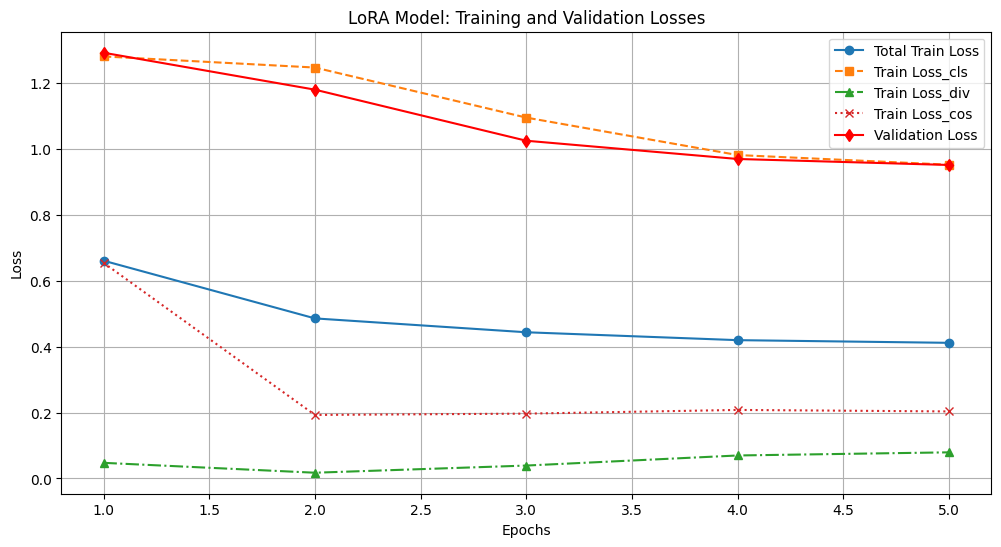

In [48]:
import torch
import matplotlib.pyplot as plt

# Load saved results
results = torch.load("lora_training_results.pt")

# Extract losses
train_losses = results["train_losses"]
train_losses_cls = results["train_cls"]
train_losses_div = results["train_div"]
train_losses_cos = results["train_cos"]
eval_losses = results["eval_losses"]

# Define epochs list
num_epochs = len(train_losses)  # Ensure consistency
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label="Total Train Loss", marker='o')
plt.plot(epochs_list, train_losses_cls, label="Train Loss_cls", marker='s', linestyle="--")
plt.plot(epochs_list, train_losses_div, label="Train Loss_div", marker='^', linestyle="-.")
plt.plot(epochs_list, train_losses_cos, label="Train Loss_cos", marker='x', linestyle=":")
plt.plot(epochs_list, eval_losses, label="Validation Loss", marker='d', linestyle="-", color="red")

plt.title('LoRA Model: Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [53]:
from transformers import BertForSequenceClassification
model = odd_model
# Now load the state dict
model.load_state_dict(torch.load('odd_model.pt', map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [54]:
# Determine the device to use (GPU if available, else CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load your tokenizer (make sure it's the one used during training)
tokenizer = AutoTokenizer.from_pretrained("./saved_tokenizer")

# Sample text input.
text = "i hate you"
inputs = tokenizer(text, return_tensors="pt")

# Move the model and inputs to the same device
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Perform inference within a no_grad() context to disable gradient tracking.
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

# For classification, choose the class with the highest logit.
predicted_class_id = torch.argmax(logits, dim=-1).item()
label_mapping = {0: 'noHate', 1: 'hate', 2: 'idk/skip', 3: 'relation'}
predicted_label = label_mapping[predicted_class_id]
print("Predicted label:", predicted_label)

Predicted label: noHate


In [55]:
odd_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

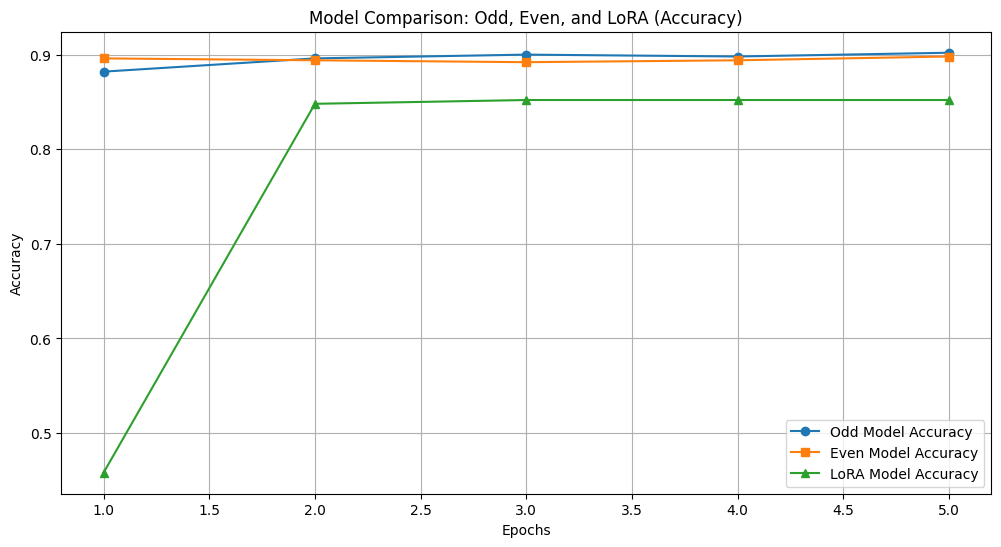

In [56]:
import matplotlib.pyplot as plt

# Plotting accuracy for all models
plt.figure(figsize=(12, 6))

# Plot accuracies for odd model
plt.plot(range(1, num_epochs + 1), odd_results["accuracies_per_epoch"], label="Odd Model Accuracy", marker='o')

# Plot accuracies for even model
plt.plot(range(1, num_epochs + 1), even_results["accuracies_per_epoch"], label="Even Model Accuracy", marker='s')

# Plot accuracies for LoRA model
plt.plot(range(1, num_epochs + 1), lora_results["accuracies_per_epoch"], label="LoRA Model Accuracy", marker='^')

# Title and labels
plt.title('Model Comparison: Odd, Even, and LoRA (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
